In [ ]:
import os
import numpy as np
import m hiatplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, Input)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
import tensorflow as tf
import numpy as np

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


TensorFlow version: 2.17.1
NumPy version: 1.26.4


In [ ]:
!kaggle competitions download -c ml-olympiad-agrisol

100% 1.70G/1.70G [01:13<00:00, 27.8MB/s]
100% 1.70G/1.70G [01:13<00:00, 24.9MB/s]


In [ ]:
!unzip /content/ml-olympiad-agrisol.zip -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3088).JPG  
  inflating: /content/dataset/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3089).JPG  
  inflating: /content/dataset/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (309).JPG  
  inflating: /content/dataset/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3090).JPG  
  inflating: /content/dataset/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (3091).JPG  
  inflating: /c

In [ ]:
!ls /content/dataset


Plant_leaf_diseases_dataset_with_augmentation  Plant_leaf_diseases_dataset_without_augmentation


In [ ]:
dataset_dir = '/content/dataset/Plant_leaf_diseases_dataset_with_augmentation/Plant_leave_diseases_dataset_with_augmentation'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 49197 images belonging to 39 classes.
Found 12289 images belonging to 39 classes.


In [ ]:
import json

class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

with open('class_indices.json', 'w') as f:
    json.dump(class_labels, f)

import pickle
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(class_indices, f)


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_tensor=Input(shape=(224, 224, 3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy',
                             save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, verbose=1, min_lr=1e-6)

callbacks = [checkpoint, earlystop, reduce_lr]


<ipython-input-21-edd1096e12a4>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,


In [ ]:
train_steps = train_generator.samples // train_generator.batch_size
valid_steps = valid_generator.samples // valid_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 497s 322ms/step - accuracy: 0.9549 - loss: 0.1513 - val_accuracy: 0.1989 - val_loss: 13.1107 - learning_rate: 0.0010
Epoch 2/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 0.9375 - loss: 0.1673 - val_accuracy: 0.0000e+00 - val_loss: 3.8976 - learning_rate: 0.0010
Epoch 3/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 499s 323ms/step - accuracy: 0.9588 - loss: 0.1430 - val_accuracy: 0.8065 - val_loss: 1.2994 - learning_rate: 0.0010
Epoch 4/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 5/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 495s 320ms/step - accuracy: 0.9637 - loss: 0.1223 - val_accuracy: 0.6635 - val_loss: 2.4319 - learning_rate: 0.0010
Epoch 6/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.9062 - loss: 0.5080 - val_accuracy: 0.0000e+00 - val_loss: 9.8740 - learning_rate: 0.0010
Epoch 7/15
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/

In [ ]:
model.load_weights('best_model.keras')

val_loss, val_acc = model.evaluate(valid_generator, steps=valid_steps)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.8035 - loss: 1.3596
Validation Accuracy: 80.32%


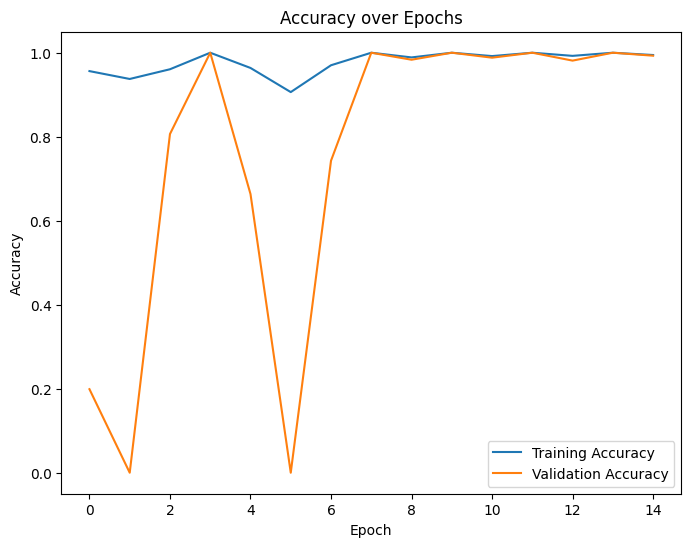

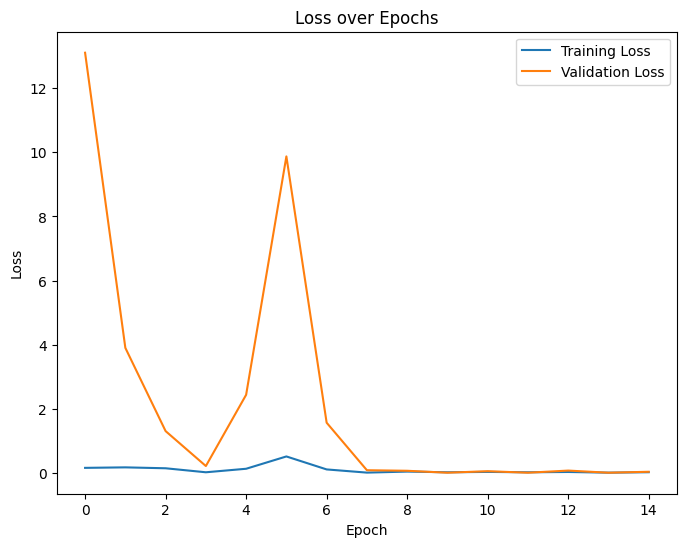

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import cv2

def predict_disease(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    pred_class = np.argmax(preds, axis=1)[0]
    disease = class_labels[pred_class]
    confidence = preds[0][pred_class]

    print(f"Predicted Disease: {disease.replace('_', ' ')}")
    print(f"Confidence: {confidence * 100:.2f}%")

image_path = '/content/dataset/Plant_leaf_diseases_dataset_with_augmentation/Plant_leave_diseases_dataset_with_augmentation/Apple___Cedar_apple_rust/image (1).JPG'
predict_disease(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Disease: Apple   Cedar apple rust
Confidence: 100.00%


In [ ]:
model.save('final_model.keras')


In [ ]:
from google.colab import files
files.download('final_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>